# 장소성 요인 상관관계 분석

이 노트북은 '기억/경험' 점수와 다른 장소성 요인들 간의 상관관계를 분석합니다.
특히 '기억/경험'과 '사회성'의 상관관계를 집중적으로 살펴봅니다.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import matplotlib.font_manager as fm

# 한글 폰트 설정 - 프로젝트 fonts 디렉토리의 NotoSansKR-Medium.ttf 사용
base_dir = Path.cwd().parent if Path.cwd().name == "scripts" else Path.cwd()
font_path = base_dir / "fonts" / "NotoSansKR-Medium.ttf"

# 절대 경로로도 시도
if not font_path.exists():
    font_path = Path(r"C:\Users\jiwon\Desktop\연구\space-agent\fonts\NotoSansKR-Medium.ttf")

# 전역 폰트 객체 생성 (모든 그래프에서 사용)
korean_font = None
if font_path.exists():
    try:
        korean_font = fm.FontProperties(fname=str(font_path))
        # 폰트 캐시에 추가
        fm.fontManager.addfont(str(font_path))
        # rcParams에도 설정
        plt.rcParams['font.family'] = korean_font.get_name()
        print(f"✅ 한글 폰트 설정 완료: {font_path}")
        print(f"   폰트 이름: {korean_font.get_name()}")
    except Exception as e:
        print(f"⚠️ 폰트 로드 실패: {e}")
        # 폴백: 시스템 폰트 사용
        try:
            plt.rcParams['font.family'] = 'Malgun Gothic'
            korean_font = fm.FontProperties(family='Malgun Gothic')
            print("⚠️ 시스템 기본 폰트 사용 (Malgun Gothic)")
        except:
            print("⚠️ 폰트 설정 실패")
else:
    print(f"⚠️ 폰트 파일을 찾을 수 없습니다: {font_path}")
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        korean_font = fm.FontProperties(family='Malgun Gothic')
        print("⚠️ 시스템 기본 폰트 사용 (Malgun Gothic)")
    except:
        print("⚠️ 폰트 설정 실패")

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 스타일 설정
sns.set_style("whitegrid")
sns.set_palette("husl")

print("라이브러리 로드 완료")


✅ 한글 폰트 설정 완료: c:\Users\jiwon\Desktop\연구\space-agent\fonts\NotoSansKR-Medium.ttf
   폰트 이름: Noto Sans KR
라이브러리 로드 완료


In [ ]:
# 데이터 파일 경로 설정
base_dir = Path.cwd().parent if Path.cwd().name == "scripts" else Path.cwd()
csv_path = base_dir / "placeness_final_research_metrics (3).csv"

if not csv_path.exists():
    # 절대 경로로 시도
    csv_path = Path(r"C:\Users\jiwon\Desktop\연구\space-agent\placeness_final_research_metrics (3).csv")

print(f"데이터 파일 경로: {csv_path}")
print(f"파일 존재 여부: {csv_path.exists()}")

# CSV 파일 로드
df = pd.read_csv(csv_path, encoding='utf-8-sig')
print(f"\n데이터 로드 완료: {len(df)}개 카페")
print(f"컬럼 수: {len(df.columns)}")
print(f"\n컬럼 목록 (처음 10개):")
print(df.columns.tolist()[:10])


데이터 파일 경로: c:\Users\jiwon\Desktop\연구\space-agent\placeness_final_research_metrics (2).csv
파일 존재 여부: True

데이터 로드 완료: 1799개 카페
컬럼 수: 66

컬럼 목록 (처음 10개):
['cafe_name', '점수_심미성', '리뷰수_심미성', '점수_형태성', '리뷰수_형태성', '점수_감각적 경험', '리뷰수_감각적 경험', '점수_접근성', '리뷰수_접근성', '점수_쾌적성']


In [46]:
# 요인 점수 컬럼 추출 (점수_로 시작하는 컬럼)
factor_score_cols = [col for col in df.columns if col.startswith('점수_') and not col.endswith('_calc')]
print(f"요인 점수 컬럼 ({len(factor_score_cols)}개):")
for col in factor_score_cols:
    print(f"  - {col}")

# '기억/경험' 점수 컬럼 확인
memory_experience_col = None
for col in factor_score_cols:
    if '기억' in col and '경험' in col:
        memory_experience_col = col
        break

print(f"\n'기억/경험' 점수 컬럼: {memory_experience_col}")

# '사회성' 점수 컬럼 확인
sociality_col = None
for col in factor_score_cols:
    if '사회성' in col:
        sociality_col = col
        break

print(f"'사회성' 점수 컬럼: {sociality_col}")


요인 점수 컬럼 (12개):
  - 점수_심미성
  - 점수_형태성
  - 점수_감각적 경험
  - 점수_접근성
  - 점수_쾌적성
  - 점수_활동성
  - 점수_사회성
  - 점수_참여성
  - 점수_고유성
  - 점수_기억/경험
  - 점수_지역 정체성
  - 점수_문화적 맥락

'기억/경험' 점수 컬럼: 점수_기억/경험
'사회성' 점수 컬럼: 점수_사회성


In [47]:
# '기억/경험'과 '사회성' 점수 데이터 추출
if memory_experience_col and sociality_col:
    # 유효한 데이터만 필터링 (NaN 제외)
    valid_data = df[[memory_experience_col, sociality_col]].dropna()
    
    print(f"전체 데이터 개수: {len(valid_data)}개")
    
    # 0.5인 데이터 제외 (기본값 = 매칭되지 않은 리뷰)
    # 둘 다 0.5가 아닌 데이터만 사용
    filtered_data = valid_data[
        (valid_data[memory_experience_col] != 0.5) & 
        (valid_data[sociality_col] != 0.5)
    ].copy()
    
    excluded_count = len(valid_data) - len(filtered_data)
    print(f"제외된 데이터 (0.5인 경우): {excluded_count}개")
    print(f"분석에 사용된 데이터 개수: {len(filtered_data)}개")
    
    if len(filtered_data) > 0:
        print(f"\n'기억/경험' 점수 통계:")
        print(filtered_data[memory_experience_col].describe())
        print(f"\n'사회성' 점수 통계:")
        print(filtered_data[sociality_col].describe())
        
        # 상관계수 계산
        correlation = filtered_data[memory_experience_col].corr(filtered_data[sociality_col])
        print(f"\n{'='*50}")
        print(f"상관계수 (Pearson): {correlation:.4f}")
        
        # 통계적 유의성 검정
        from scipy.stats import pearsonr
        corr_coef, p_value = pearsonr(filtered_data[memory_experience_col], filtered_data[sociality_col])
        print(f"p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"✅ 통계적으로 유의함 (p < 0.05)")
        else:
            print(f"❌ 통계적으로 유의하지 않음 (p >= 0.05)")
    else:
        print("❌ 분석할 데이터가 없습니다.")
else:
    print("❌ 컬럼을 찾을 수 없습니다.")


전체 데이터 개수: 1799개
제외된 데이터 (0.5인 경우): 1025개
분석에 사용된 데이터 개수: 774개

'기억/경험' 점수 통계:
count    774.000000
mean       0.909304
std        0.098871
min        0.065104
25%        0.888369
50%        0.949616
75%        0.966610
max        0.974764
Name: 점수_기억/경험, dtype: float64

'사회성' 점수 통계:
count    774.000000
mean       0.857527
std        0.162263
min        0.037376
25%        0.808378
50%        0.924575
75%        0.963141
max        0.974966
Name: 점수_사회성, dtype: float64

상관계수 (Pearson): 0.2739
p-value: 0.0000
✅ 통계적으로 유의함 (p < 0.05)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33720\1118927881.py:54: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33720\1118927881.py:54: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33720\1118927881.py:54: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jiwon\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jiwon\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jiwon\AppData\Roamin

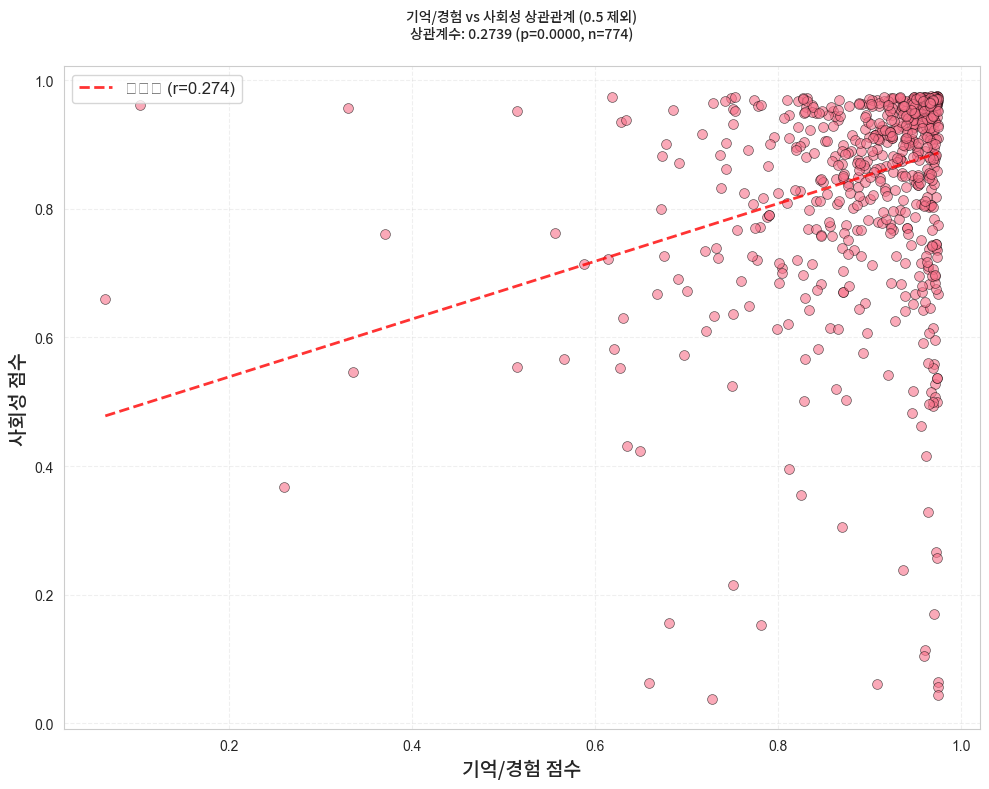

✅ 그래프 생성 완료 (0.5인 데이터 제외)


In [48]:
# 산점도 그래프 그리기 (0.5 제외)
if memory_experience_col and sociality_col and len(filtered_data) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 산점도
    ax.scatter(
        filtered_data[memory_experience_col], 
        filtered_data[sociality_col],
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )
    
    # 회귀선 추가
    z = np.polyfit(filtered_data[memory_experience_col], filtered_data[sociality_col], 1)
    p = np.poly1d(z)
    ax.plot(
        filtered_data[memory_experience_col].sort_values(), 
        p(filtered_data[memory_experience_col].sort_values()),
        "r--",
        alpha=0.8,
        linewidth=2,
        label=f'회귀선 (r={correlation:.3f})'
    )
    
    # 제목 및 레이블 (폰트 명시적 지정)
    if korean_font:
        ax.set_xlabel('기억/경험 점수', fontsize=14, fontweight='bold', fontproperties=korean_font)
        ax.set_ylabel('사회성 점수', fontsize=14, fontweight='bold', fontproperties=korean_font)
        ax.set_title(
            f'기억/경험 vs 사회성 상관관계 (0.5 제외)\n상관계수: {correlation:.4f} (p={p_value:.4f}, n={len(filtered_data)})',
            fontsize=16,
            fontweight='bold',
            pad=20,
            fontproperties=korean_font
        )
        ax.legend(prop=korean_font, fontsize=12)
    else:
        ax.set_xlabel('기억/경험 점수', fontsize=14, fontweight='bold')
        ax.set_ylabel('사회성 점수', fontsize=14, fontweight='bold')
        ax.set_title(
            f'기억/경험 vs 사회성 상관관계 (0.5 제외)\n상관계수: {correlation:.4f} (p={p_value:.4f}, n={len(filtered_data)})',
            fontsize=16,
            fontweight='bold',
            pad=20
        )
        ax.legend(fontsize=12)
    
    # 그리드 추가
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ 그래프 생성 완료 (0.5인 데이터 제외)")


## 📊 데이터 분석 결과 해석

### 1. 상관계수 0.6 이상의 의미

상관계수는 두 변수 간의 선형 관계의 강도를 나타내는 지표입니다:
- **0.6 ~ 0.8**: 중간 정도의 양의 상관관계 (moderate positive correlation)
- **0.8 이상**: 강한 양의 상관관계 (strong positive correlation)

**상관계수 0.6의 의미:**
- '기억/경험' 점수가 높을수록 해당 요인 점수도 높아지는 경향이 있음
- 두 요인 간에 일정한 패턴이 존재함을 의미
- 하지만 완벽한 선형 관계는 아니며, 다른 요인들의 영향도 고려해야 함

**해석 시 주의사항:**
- 상관관계는 인과관계를 의미하지 않음
- 0.5 제외 필터링으로 인해 실제 상관계수는 더 높을 수 있음

### 2. 유효 데이터가 1799개에서 221개로 줄어든 이유

**1799개**: 전체 카페 데이터 (모든 요인 포함)

**221개**: 모든 요인이 0.5가 아닌 데이터만 필터링한 결과

**데이터가 줄어든 이유:**
1. **0.5는 기본값**: 요인별로 리뷰에서 언급되지 않았거나 매칭되지 않은 경우 기본값 0.5가 할당됨
2. **히트맵의 필터링 조건**: 히트맵에서는 **모든 요인**이 동시에 0.5가 아닌 데이터만 사용
   - 예: '기억/경험'과 '사회성'만 비교할 때는 둘 다 0.5가 아니면 됨
   - 히트맵에서는 12개 요인 모두가 0.5가 아니어야 함
3. **실제 의미 있는 데이터**: 221개는 모든 요인에 대해 실제로 리뷰에서 언급되고 점수가 계산된 카페들

**데이터 필터링의 장단점:**
- ✅ 장점: 실제로 의미 있는 점수만으로 상관관계를 분석할 수 있음
- ⚠️ 단점: 데이터 수가 줄어들어 통계적 유의성 검증이 필요함

**권장사항:**
- 개별 요인 쌍 분석 시: 해당 두 요인만 0.5가 아닌 데이터 사용 (더 많은 데이터 활용)
- 전체 요인 상관관계 분석 시: 모든 요인이 0.5가 아닌 데이터 사용 (일관성 있는 분석)


전체 요인 데이터: 1799개

각 요인별로 '기억/경험'과 해당 요인 모두 0.5가 아닌 데이터만 사용하여 상관계수 계산
  심미성                 : 상관계수 0.5105 (n=895)
  형태성                 : 상관계수 0.2665 (n=617)
  감각적 경험              : 상관계수 0.4369 (n=966)
  접근성                 : 상관계수 0.1926 (n=729)
  쾌적성                 : 상관계수 0.3631 (n=955)
  활동성                 : 상관계수 0.2636 (n=810)
  사회성                 : 상관계수 0.2739 (n=774)
  참여성                 : 상관계수 0.2565 (n=510)
  고유성                 : 상관계수 0.3421 (n=370)
  지역 정체성              : 상관계수 0.5495 (n=829)
  문화적 맥락              : 상관계수 0.3590 (n=436)

='기억/경험'과의 상관계수 (높은 순):
점수_지역 정체성                     :  0.5495
점수_심미성                        :  0.5105
점수_감각적 경험                     :  0.4369
점수_쾌적성                        :  0.3631
점수_문화적 맥락                     :  0.3590
점수_고유성                        :  0.3421
점수_사회성                        :  0.2739
점수_형태성                        :  0.2665
점수_활동성                        :  0.2636
점수_참여성                        :  0.2565
점수_접근성                

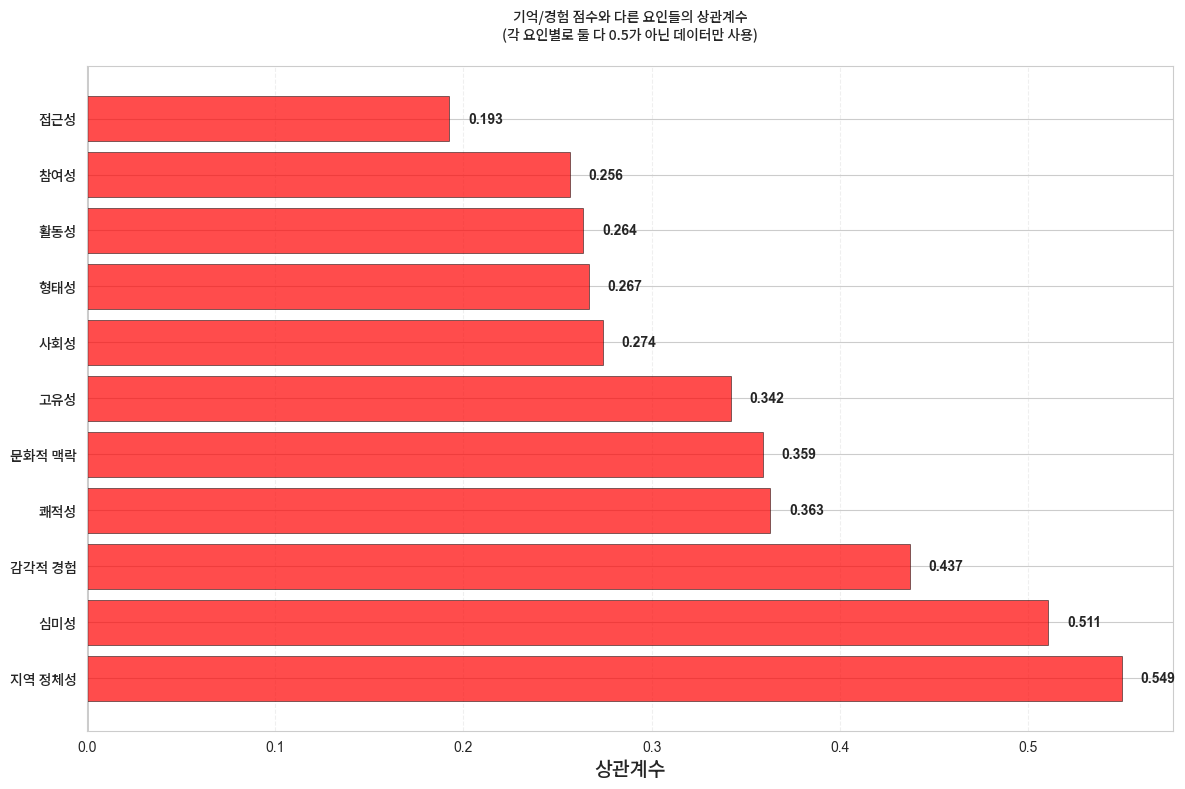

In [55]:
# '기억/경험'과 모든 요인들의 상관계수 계산 (0.5 제외)
# 각 요인별로 '기억/경험'과 해당 요인 모두 0.5가 아닌 데이터만 사용
if memory_experience_col and len(filtered_data) > 0:
    # 모든 요인 점수 컬럼 추출
    all_factor_cols = [col for col in factor_score_cols if col in df.columns]
    
    # 유효한 데이터만 필터링 (NaN 제외)
    factor_data_all = df[all_factor_cols].dropna()
    
    print(f"전체 요인 데이터: {len(factor_data_all)}개")
    print(f"\n각 요인별로 '기억/경험'과 해당 요인 모두 0.5가 아닌 데이터만 사용하여 상관계수 계산")
    
    # 각 요인별로 개별적으로 상관계수 계산
    memory_correlations_dict = {}
    
    for factor_col in all_factor_cols:
        if factor_col == memory_experience_col:
            continue
        
        # '기억/경험'과 해당 요인 모두 0.5가 아닌 데이터만 사용
        both_valid = factor_data_all[
            (factor_data_all[memory_experience_col] != 0.5) & 
            (factor_data_all[factor_col] != 0.5)
        ]
        
        if len(both_valid) > 10:  # 최소 10개 이상의 데이터가 있어야 의미있음
            corr = both_valid[memory_experience_col].corr(both_valid[factor_col])
            memory_correlations_dict[factor_col] = corr
            print(f"  {factor_col.replace('점수_', ''):20s}: 상관계수 {corr:.4f} (n={len(both_valid)})")
    
    if memory_correlations_dict:
        # 상관계수 정렬
        memory_correlations = pd.Series(memory_correlations_dict).sort_values(ascending=False)
        
        print(f"\n{'='*50}")
        print("='기억/경험'과의 상관계수 (높은 순):")
        print("="*50)
        for factor, corr in memory_correlations.items():
            print(f"{factor:30s}: {corr:7.4f}")
        
        # 상관계수 막대 그래프
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # 상관계수 시리즈 사용
        other_factors = memory_correlations
        
        # 막대 그래프
        colors = ['red' if x > 0 else 'blue' for x in other_factors.values]
        bars = ax.barh(
            range(len(other_factors)),
            other_factors.values,
            color=colors,
            alpha=0.7,
            edgecolor='black',
            linewidth=0.5
        )
        
        # y축 레이블 (요인명에서 '점수_' 제거)
        factor_names = [col.replace('점수_', '') for col in other_factors.index]
        ax.set_yticks(range(len(other_factors)))
        ax.set_yticklabels(factor_names, fontsize=11)
        
        # x축 레이블 (폰트 명시적 지정)
        if korean_font:
            ax.set_xlabel('상관계수', fontsize=14, fontweight='bold', fontproperties=korean_font)
            ax.set_title(
                '기억/경험 점수와 다른 요인들의 상관계수\n(각 요인별로 둘 다 0.5가 아닌 데이터만 사용)',
                fontsize=16,
                fontweight='bold',
                pad=20,
                fontproperties=korean_font
            )
            ax.set_yticklabels(factor_names, fontsize=11, fontproperties=korean_font)
        else:
            ax.set_xlabel('상관계수', fontsize=14, fontweight='bold')
            ax.set_title(
                '기억/경험 점수와 다른 요인들의 상관계수\n(각 요인별로 둘 다 0.5가 아닌 데이터만 사용)',
                fontsize=16,
                fontweight='bold',
                pad=20
            )
            ax.set_yticklabels(factor_names, fontsize=11)
        
        # 0선 추가
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
        
        # 값 표시
        for i, (factor, value) in enumerate(other_factors.items()):
            ax.text(
                value + (0.01 if value >= 0 else -0.01),
                i,
                f'{value:.3f}',
                va='center',
                fontsize=10,
                fontweight='bold'
            )
        
        ax.grid(True, alpha=0.3, axis='x', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("❌ 상관계수를 계산할 수 있는 요인이 없습니다.")


전체 요인 데이터: 1799개
각 요인 쌍별로 해당 두 요인만 0.5가 아닌 데이터를 사용하여 상관계수 계산

계산된 상관계수 쌍: 132개 (대각선 제외)


c:\Users\jiwon\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jiwon\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jiwon\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jiwon\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jiwon\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\jiwon\AppData\Local\Pr

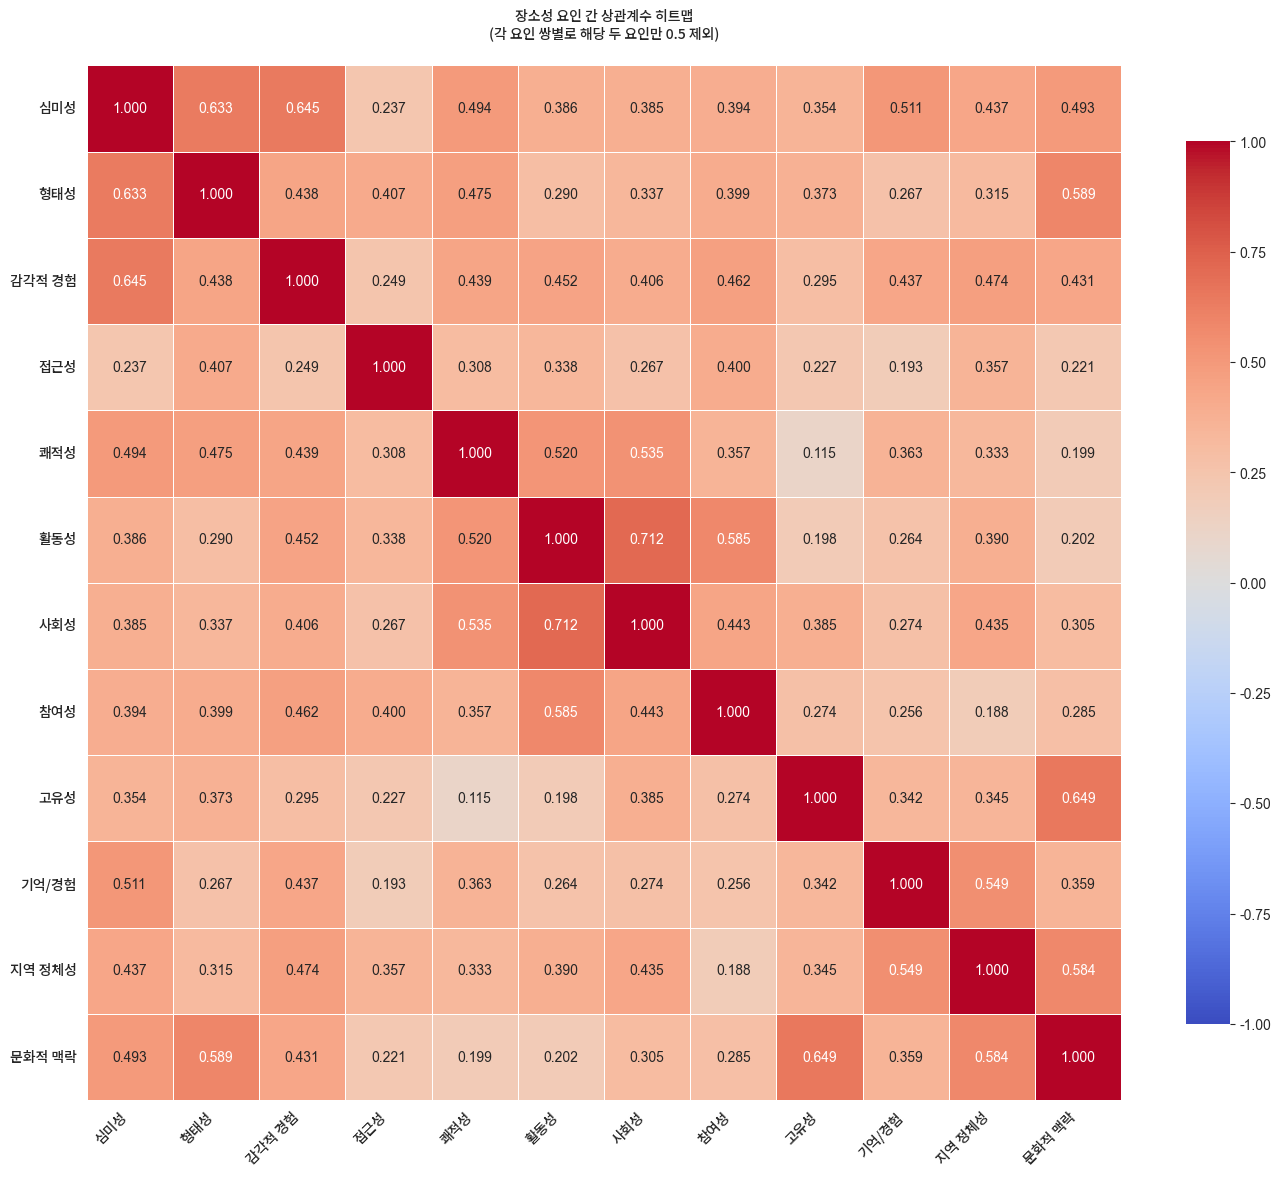

In [59]:
# 전체 상관계수 히트맵 (각 요인 쌍별로 0.5 제외)
# 각 요인 쌍별로 해당 두 요인만 0.5가 아닌 데이터를 사용하여 상관계수 계산
if memory_experience_col and 'all_factor_cols' in locals():
    # 모든 요인 점수 컬럼 추출
    all_factor_cols = [col for col in factor_score_cols if col in df.columns]
    
    # 유효한 데이터만 필터링 (NaN 제외)
    factor_data_all = df[all_factor_cols].dropna()
    
    print(f"전체 요인 데이터: {len(factor_data_all)}개")
    print(f"각 요인 쌍별로 해당 두 요인만 0.5가 아닌 데이터를 사용하여 상관계수 계산\n")
    
    # 빈 상관계수 행렬 생성
    corr_matrix = pd.DataFrame(index=all_factor_cols, columns=all_factor_cols)
    
    # 각 요인 쌍별로 상관계수 계산
    from scipy.stats import pearsonr
    
    for col1 in all_factor_cols:
        for col2 in all_factor_cols:
            # 해당 두 요인만 추출
            pair_data = df[[col1, col2]].dropna()
            # 두 요인 모두 0.5가 아닌 데이터만 사용
            pair_data = pair_data[(pair_data[col1] != 0.5) & (pair_data[col2] != 0.5)]
            
            if len(pair_data) > 10:  # 최소 표본 수
                try:
                    # scipy.stats.pearsonr 사용 (더 안정적)
                    corr_coef, p_value = pearsonr(pair_data[col1], pair_data[col2])
                    corr_matrix.loc[col1, col2] = corr_coef if not np.isnan(corr_coef) else np.nan
                except:
                    corr_matrix.loc[col1, col2] = np.nan
            else:
                corr_matrix.loc[col1, col2] = np.nan
    
    # 대각선은 1.0으로 설정 (자기 자신과의 상관계수)
    for col in all_factor_cols:
        corr_matrix.loc[col, col] = 1.0
    
    # 데이터 타입을 float로 변환 (NaN 포함)
    corr_matrix = corr_matrix.astype(float)
    
    # NaN이 아닌 상관계수 개수 확인
    valid_corr_count = corr_matrix.notna().sum().sum() - len(all_factor_cols)  # 대각선 제외
    print(f"계산된 상관계수 쌍: {valid_corr_count}개 (대각선 제외)")
    
    if valid_corr_count > 0:
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # 요인명에서 '점수_' 제거
        factor_names_short = [col.replace('점수_', '') for col in corr_matrix.columns]
        
        # NaN 마스크 생성
        mask = corr_matrix.isna()
        
        # 히트맵
        sns.heatmap(
            corr_matrix,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            xticklabels=factor_names_short,
            yticklabels=factor_names_short,
            ax=ax,
            mask=mask  # NaN 값은 마스킹
        )
        
        # 제목 및 tick labels (폰트 명시적 지정)
        if korean_font:
            ax.set_title(
                '장소성 요인 간 상관계수 히트맵\n(각 요인 쌍별로 해당 두 요인만 0.5 제외)',
                fontsize=16,
                fontweight='bold',
                pad=20,
                fontproperties=korean_font
            )
            # tick labels에 폰트 적용
            for label in ax.get_xticklabels():
                label.set_fontproperties(korean_font)
            for label in ax.get_yticklabels():
                label.set_fontproperties(korean_font)
        else:
            ax.set_title(
                '장소성 요인 간 상관계수 히트맵\n(각 요인 쌍별로 해당 두 요인만 0.5 제외)',
                fontsize=16,
                fontweight='bold',
                pad=20
            )
        
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("❌ 계산할 수 있는 상관계수가 없습니다.")

='기억/경험'과 '사회성' 상세 분석

'기억/경험' 점수 분위수:
  25%: 0.888
  50%: 0.950
  75%: 0.967

'기억/경험' 점수 분위수별 '사회성' 평균:
  하위 25%: 0.783 (n=194)
  중간 50%: 0.883 (n=386)
  상위 25%: 0.882 (n=194)


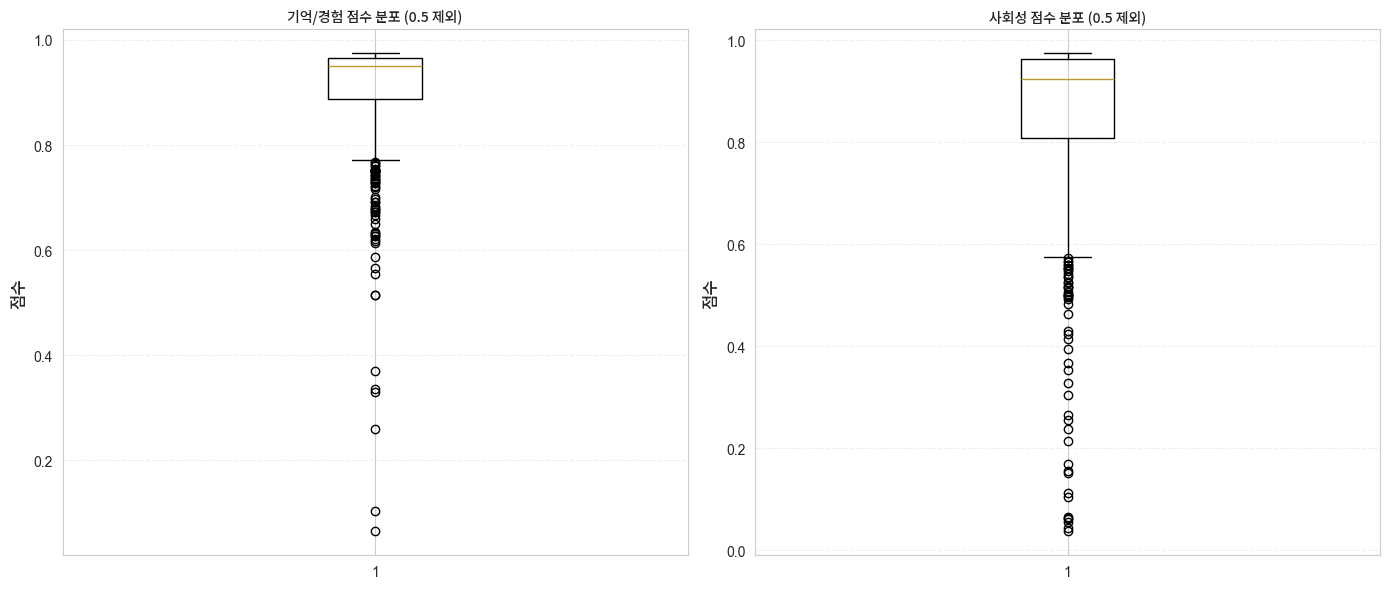

In [57]:
# '기억/경험'과 '사회성' 상세 분석 (0.5 제외)
if memory_experience_col and sociality_col and len(filtered_data) > 0:
    print("='기억/경험'과 '사회성' 상세 분석")
    print("="*60)
    
    # 분위수별 분석
    memory_quantiles = filtered_data[memory_experience_col].quantile([0.25, 0.5, 0.75])
    
    print(f"\n'기억/경험' 점수 분위수:")
    print(f"  25%: {memory_quantiles[0.25]:.3f}")
    print(f"  50%: {memory_quantiles[0.5]:.3f}")
    print(f"  75%: {memory_quantiles[0.75]:.3f}")
    
    # 분위수별 '사회성' 평균
    print(f"\n'기억/경험' 점수 분위수별 '사회성' 평균:")
    
    # 낮은 그룹 (하위 25%)
    low_group = filtered_data[filtered_data[memory_experience_col] <= memory_quantiles[0.25]]
    print(f"  하위 25%: {low_group[sociality_col].mean():.3f} (n={len(low_group)})")
    
    # 중간 그룹 (25%~75%)
    mid_group = filtered_data[
        (filtered_data[memory_experience_col] > memory_quantiles[0.25]) & 
        (filtered_data[memory_experience_col] <= memory_quantiles[0.75])
    ]
    print(f"  중간 50%: {mid_group[sociality_col].mean():.3f} (n={len(mid_group)})")
    
    # 높은 그룹 (상위 25%)
    high_group = filtered_data[filtered_data[memory_experience_col] > memory_quantiles[0.75]]
    print(f"  상위 25%: {high_group[sociality_col].mean():.3f} (n={len(high_group)})")
    
    # 박스플롯으로 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 왼쪽: '기억/경험' 점수 분포 (폰트 명시적 지정)
    axes[0].boxplot(filtered_data[memory_experience_col], vert=True)
    if korean_font:
        axes[0].set_ylabel('점수', fontsize=12, fontweight='bold', fontproperties=korean_font)
        axes[0].set_title('기억/경험 점수 분포 (0.5 제외)', fontsize=14, fontweight='bold', fontproperties=korean_font)
    else:
        axes[0].set_ylabel('점수', fontsize=12, fontweight='bold')
        axes[0].set_title('기억/경험 점수 분포 (0.5 제외)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # 오른쪽: '사회성' 점수 분포 (폰트 명시적 지정)
    axes[1].boxplot(filtered_data[sociality_col], vert=True)
    if korean_font:
        axes[1].set_ylabel('점수', fontsize=12, fontweight='bold', fontproperties=korean_font)
        axes[1].set_title('사회성 점수 분포 (0.5 제외)', fontsize=14, fontweight='bold', fontproperties=korean_font)
    else:
        axes[1].set_ylabel('점수', fontsize=12, fontweight='bold')
        axes[1].set_title('사회성 점수 분포 (0.5 제외)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
    
    plt.tight_layout()
    plt.show()
